### **Import required packages and functions**

In [9]:
import numpy as np
import math
import random
from scipy import stats
from sklearn.metrics import auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D


### **Function for one hot encoding of DNA sequence**

In [2]:
def One_Hot_Encode(seq):
    baseDict = {"A":0, "C":1, "G":2, "T":3}
    oneHotArray = []
    seq = seq.upper()
    seqArray = np.array(list(seq))
    for base in seqArray:
        code = [0, 0, 0, 0]
        if base in baseDict:
            code[baseDict[base]] = 1
        else:
            code = [0.25, 0.25, 0.25, 0.25]
        oneHotArray.append(code)
    return oneHotArray

### **Function for processing FASTA sequence files**

In [3]:
def Process_Sequences(fasta):
    elementList = [next(fasta).lstrip(">").rstrip()]
    inputData = []
    seq=''
    for line in fasta:
        if ">" not in line:
            seq += line.rstrip()
        else:
            inputData.append(One_Hot_Encode(seq))
            elementList.append(line.lstrip(">"))
            seq=''
    inputData.append(One_Hot_Encode(seq))
    inputData = np.array(inputData)
    inputData = inputData.reshape(inputData.shape[0], 200, 4)
    return elementList, inputData

### **Function for processing labels**

In [4]:
def Process_Labels(labels):
    labArray = []
    for line in labels:
        line = line.rstrip().split("\t")
        labArray.append(float(line[1]))
    labArray = np.array(labArray)
    labArray = labArray.reshape(labArray.shape[0],1)
    return labArray

### **Function creating CNN model**

In [5]:
def Create_CNN_model(seqLength):

    inputSeq = Input(shape=(seqLength,4), name="Input")
     
    x = Conv1D(filters=8, kernel_size=10, strides=1, activation="relu", name="Conv1D-1")(inputSeq)
    x = MaxPooling1D(pool_size=4, name="MaxPool-1")(x)
    x = Flatten(name="Flatten-1")(x)
    x = Dense(8, activation="relu", name="Dense-1")(x)
    
    output = Dense(1, activation="sigmoid", name="Output")(x)

    model = Model(inputs=inputSeq, outputs=output)
    model.compile(optimizer=Adam(.001), loss="binary_crossentropy", metrics=["accuracy"])
    model.summary()
    return model


### **Read in sequences and labels and split into train and test sets**

In [6]:
seqLength = 200

fasta = open("TF-Test.fa")
ccres, features = Process_Sequences(fasta)
fasta.close()

labels = open("TF-Test.Labels.txt")
labArray = Process_Labels(labels)
labels.close()

xtrain, xtest, ytrain, ytest = train_test_split(features, labArray, test_size=0.15)
print("Finished processing data ...")

Finished processing data ...


### **Train CNN model**

In [7]:
model = Create_CNN_model(seqLength)
model.fit(x=xtrain, y=ytrain, epochs=10, verbose=1, batch_size=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 4)]          0         
                                                                 
 Conv1D-1 (Conv1D)           (None, 191, 8)            328       
                                                                 
 MaxPool-1 (MaxPooling1D)    (None, 47, 8)             0         
                                                                 
 Flatten-1 (Flatten)         (None, 376)               0         
                                                                 
 Dense-1 (Dense)             (None, 8)                 3016      
                                                                 
 Output (Dense)              (None, 1)                 9         
                                                                 
Total params: 3,353
Trainable params: 3,353
Non-trainable par

2022-11-16 19:26:44.120004: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


850/850 [==============================] - 1s 1ms/step - loss: 0.6965 - accuracy: 0.4988
Epoch 2/10
850/850 [==============================] - 1s 961us/step - loss: 0.6555 - accuracy: 0.6176
Epoch 3/10
850/850 [==============================] - 1s 946us/step - loss: 0.5267 - accuracy: 0.7576
Epoch 4/10
850/850 [==============================] - 1s 968us/step - loss: 0.4297 - accuracy: 0.8059
Epoch 5/10
850/850 [==============================] - 1s 935us/step - loss: 0.3623 - accuracy: 0.8506
Epoch 6/10
850/850 [==============================] - 1s 923us/step - loss: 0.3009 - accuracy: 0.8835
Epoch 7/10
850/850 [==============================] - 1s 953us/step - loss: 0.2525 - accuracy: 0.8976
Epoch 8/10
850/850 [==============================] - 1s 924us/step - loss: 0.2044 - accuracy: 0.9271
Epoch 9/10
850/850 [==============================] - 1s 967us/step - loss: 0.1534 - accuracy: 0.9541
Epoch 10/10
850/850 [==============================] - 1s 968us/step - loss: 0.1379 - accuracy:

### **Evaluate model and calculate AUPR**

5/5 [==============================] - 0s 2ms/step
0.8809917389685212


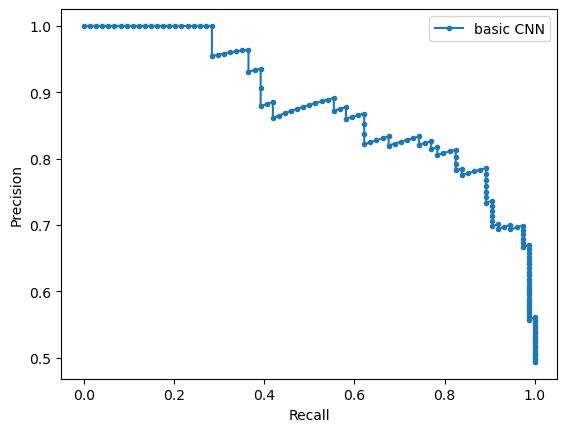

In [8]:
ypred = model.predict(xtest)

precision, recall, _ = precision_recall_curve(ytest, ypred)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision, marker='.', label='basic CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()